import and inline matplotlib

In [1]:
##
# Nan Lu (Caltech) Dec 06, 2019 for the CMS DAS school December 2019
##

import ROOT as rt
from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from xgboost import plot_tree

import pickle

Welcome to JupyROOT 6.18/00


make a random variable

In [2]:
def convert(tree):
    feature = tree2array(tree,
                        branches = id_variables+wt_variables + variables + dnn_variables,
                         selection = 'cat_index==5 && Higgs_mass >120. && Higgs_mass<130.')
    return feature

In [3]:
def convert_ntuple_dataframe(path, filename,treename):
    rootfile = rt.TFile.Open(path+filename)
    tree = rootfile.Get(treename)
    np =convert(tree)
    dataframe = pd.DataFrame.from_records(np)
    return dataframe, tree

In [4]:
path='/eos/cms/store/user/nlu/Hmm/CMSDAS122019/ntuple/vbfcategory/'
sig_FILE='vbf_amc_herwig_nominal.root'
ggh_FILE='ggh_amcPS_nominal.root'
ewz_FILE='ewk_lljj_mll105_160_nominal.root'
dy_FILE='dy_m105_160_amc_merged.root'

variables = ['softJet5','M_jj','dEta_jj','Zep','leadingJet_pt','subleadingJet_pt',
             'leadingJet_eta','subleadingJet_eta','leadingJet_qgl','subleadingJet_qgl','cthetaCS',
             'Higgs_pt','Higgs_eta','Higgs_mass']
dnn_variables=['dnnPisa_pred']
id_variables = ['run','lumi','event']
wt_variables = ['evt_weight']

dfs = []
df_sig, sigtree_vbf = convert_ntuple_dataframe(path,sig_FILE,"tree")
df_bkg_dy, bkgtree_dy = convert_ntuple_dataframe(path,dy_FILE,"tree")
df_bkg_ewz, bkgtree_ewz = convert_ntuple_dataframe(path,ewz_FILE,"tree")
df_sig_ggh, sigtree_ggh = convert_ntuple_dataframe(path,ggh_FILE,"tree")


dfs.append(df_sig)
dfs.append(df_bkg_dy)
dfs.append(df_bkg_ewz)
dfs.append(df_sig_ggh)

/cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


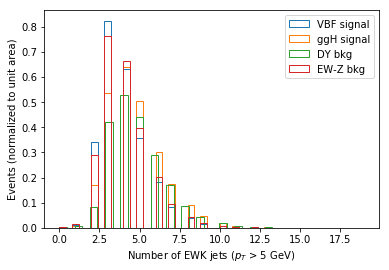

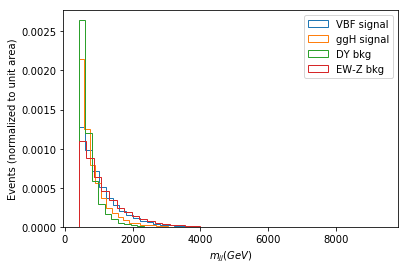

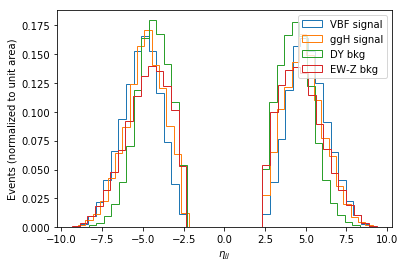

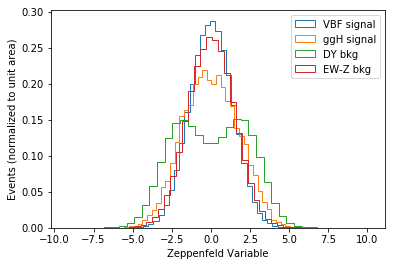

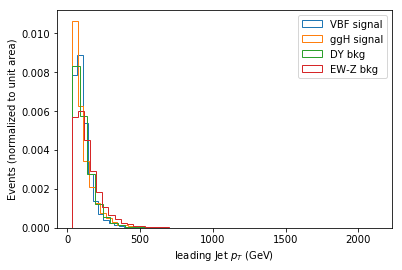

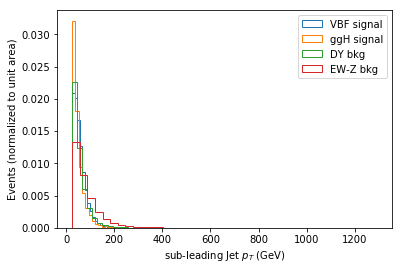

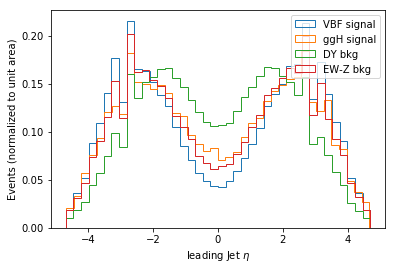

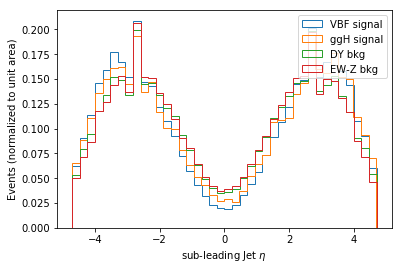

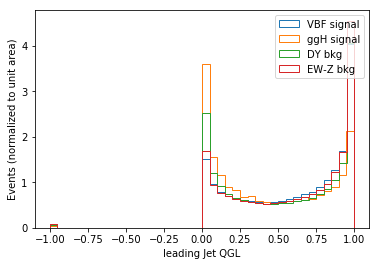

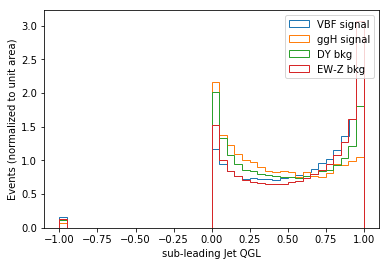

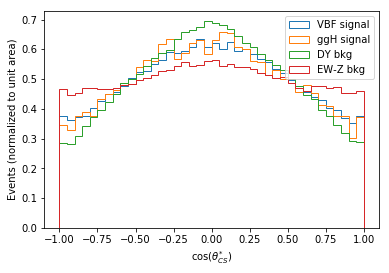

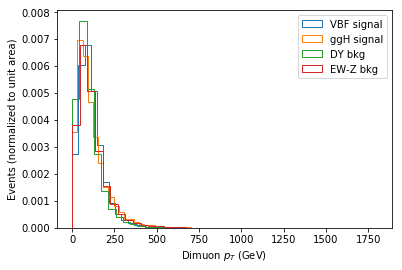

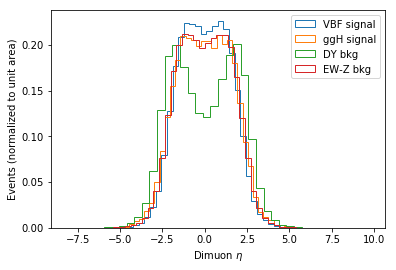

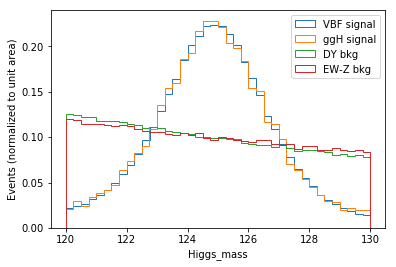

In [5]:
xlabel= ['Number of EWK jets ($p_{T}$ > 5 GeV)','$m_{jj} (GeV)$','$\eta_{jj}$','Zeppenfeld Variable', 'leading Jet $p_{T}$ (GeV)','sub-leading Jet $p_{T}$ (GeV)','leading Jet $\eta$','sub-leading Jet $\eta$','leading Jet QGL','sub-leading Jet QGL','cos($\\theta_{CS}^{*}$)','Dimuon $p_{T}$ (GeV)',
        'Dimuon $\eta$','Higgs_mass']

for hlf,xlabel_hlf in zip(variables,xlabel):
    plt.figure()
    plt.hist(dfs[0][hlf], bins=40, normed=True, histtype='step', label='VBF signal')
    plt.hist(dfs[3][hlf], bins=40, normed=True, histtype='step', label='ggH signal')
    plt.hist(dfs[1][hlf], bins=40, normed=True, histtype='step', label='DY bkg')
    plt.hist(dfs[2][hlf], bins=40, normed=True, histtype='step', label='EW-Z bkg')
    plt.xlabel(xlabel_hlf)
    plt.ylabel('Events (normalized to unit area)')
    plt.legend(loc='best')

In [5]:
var_indices = [dfs[0].columns.get_loc(v) for v in variables] # get positions of all the variables set above
dnn_var_indices = [dfs[0].columns.get_loc(v) for v in dnn_variables]
id_var_indices = [dfs[0].columns.get_loc(v) for v in id_variables]
wt_var_indices = [dfs[0].columns.get_loc(v) for v in wt_variables]

signal = dfs[0].values
background_dy = dfs[1].values
background_ewz = dfs[2].values

print("Number of VBF signal MC events:",len(signal))
print("Number of background DY MC events:",len(background_dy))
print("Number of background EWZ MC events:",len(background_ewz))

nsigw = np.sum(signal[:,wt_var_indices])
nbkgw_dy = np.sum(background_dy[:,wt_var_indices])
nbkgw_ewz = np.sum(background_ewz[:,wt_var_indices])

print("expected number of events for signal: " )
print(nsigw)
print("expected number of events for dy bkg: " )
print(nbkgw_dy)
print("expected number of events for ewz bkg: " )
print(nbkgw_ewz)

('Number of VBF signal MC events:', 215773)
('Number of background DY MC events:', 688324)
('Number of background EWZ MC events:', 197365)
expected number of events for signal: 
6.542200090558528
expected number of events for dy bkg: 
1015.4243862090698
expected number of events for ewz bkg: 
32.71495953432235


In [20]:
#signal label as 1, bkg label as 0 (ground truth)
sig_label = np.ones(len(signal))
bkg_label_dy = np.zeros(len(background_dy))
bkg_label_ewz = np.zeros(len(background_ewz))

sig_proc = np.ones(len(signal))
bkg_proc_dy = np.zeros(len(background_dy))
bkg_proc_ewz = 2*np.ones(len(background_ewz))

x = np.concatenate((signal,background_dy, background_ewz))
y = np.concatenate((sig_label,bkg_label_dy, bkg_label_ewz))
z = np.concatenate((sig_proc,bkg_proc_dy, bkg_proc_ewz))

print(x.shape)
print(y.shape)
print(z.shape)

(1101462, 19)
(1101462,)
(1101462,)


In [21]:
# split data into train and test sets
seed = 7
test_size = 0.4
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=test_size, random_state=seed)

# For training we ignore the columns with the event ID information
x_train_reduced = x_train[:,var_indices]
x_test_reduced = x_test[:,var_indices]
x_test_index = x_test[:,id_var_indices]
x_test_w = x_test[:,wt_var_indices]

[0. 0. 0. ... 1. 2. 0.]


make a one-D histogram

In [10]:
model_file = 'model_Hmm_VBFcat.pkl'

#XGBClassifier/BDT model parameters 
#https://xgboost.readthedocs.io/en/latest/python/python_api.html

depth=2
learning_rate=0.5
n_estimators=300


# fit model no training sample
model = XGBClassifier(depth,learning_rate,n_estimators)
print(model)

#early_stopping_rounds (int): Activates early stopping. Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training.
eval_set = [(x_train_reduced, y_train), (x_test_reduced, y_test)]
model.fit(x_train_reduced, y_train,early_stopping_rounds=10,eval_metric=["logloss","error"],eval_set=eval_set,verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.5,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.5,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [11]:
print("save model file ",model_file)
output = open(model_file, 'wb')
pickle.dump(model, output)
output.close()

('save model file ', 'model_Hmm_VBFcat.pkl')


In [22]:
# Read in model saved from previous running of BDT
filename="model_Hmm_VBFcat.pkl"
# load the model from disk
model = pickle.load(open(filename, 'rb'))

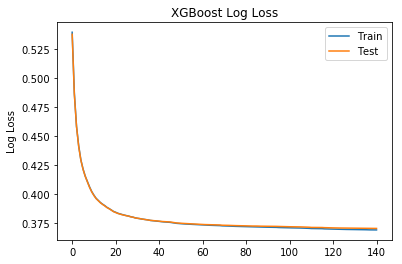

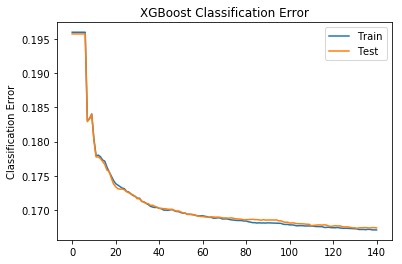

In [13]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [23]:
#make predictions for test sample
y_pred = model.predict_proba(x_test_reduced)[:, 1]

# Create a lookup table for discriminator value by event number
#disc_lookup_signal = {}
#disc_lookup_bkg = {}
#for disc_val, y_val, run, lumi, event in zip(
#        y_pred, y_test, x_test_index[:,0],
#        x_test_index[:,1], x_test_index[:,2]):
#    if y_val == 1:
#        disc_lookup_signal[(run, lumi, event)] = disc_val
#    elif y_val == 0:
#        disc_lookup_bkg[(run, lumi, event)] = disc_val

440585
(440585,)


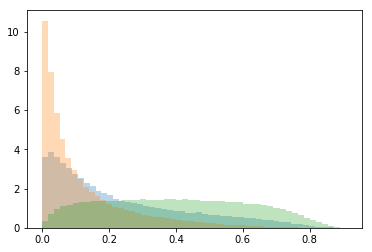

In [55]:
#label
test_name = '1212'

##########################################################
# make histogram of discriminator value for signal and bkg
##########################################################
print(len(y_test))
print(x_test[:,dnn_var_indices].flatten().shape)
y_frame = pd.DataFrame({'truth':z_test, 'disc':y_pred, 'label':y_test,'label_ref':x_test[:,dnn_var_indices].flatten()})
disc_bkg_dy    = y_frame[y_frame['truth'] == 0]['disc'].values
disc_bkg_ewz    = y_frame[y_frame['truth'] == 2]['disc'].values
disc_signal = y_frame[y_frame['truth'] == 1]['disc'].values
plt.figure()
plt.hist(disc_bkg_ewz, normed=True, bins=50, alpha=0.3)
plt.hist(disc_bkg_dy, normed=True, bins=50, alpha=0.3)
plt.hist(disc_signal, normed=True, bins=50, alpha=0.3)
plt.savefig('mydiscriminator' + test_name + '.png')

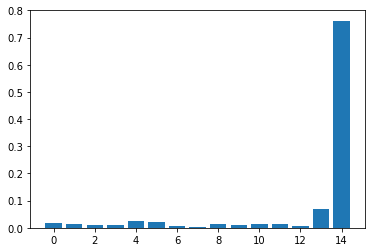

In [25]:
##########################################################
# Rank training variable of importance
##########################################################
plt.figure()
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.savefig('myImportances_' + test_name + '.png')

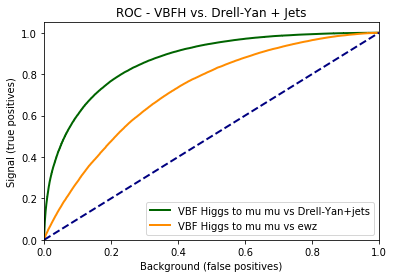

In [57]:
##########################################################
# make ROC curve
##########################################################

#get roc curve
#fpr, tpr, _ = roc_curve(y_test, y_pred, x_test_w)

#DY and VBF signal
subset_dy_vbf = y_frame.loc[(y_frame['truth'] ==0 ) | (y_frame['truth'] ==1)] 

#EWZ and VBF signal
subset_ewz_vbf = y_frame.loc[(y_frame['truth'] ==2 ) | (y_frame['truth'] ==1)] 

fpr_dy, tpr_dy, _ = roc_curve(subset_dy_vbf['label'].values, subset_dy_vbf['disc'].values)
fpr_ewz, tpr_ewz, _ = roc_curve(subset_ewz_vbf['label'].values, subset_ewz_vbf['disc'].values)


#plot roc curve
plt.figure()
lw = 2
plt.plot(fpr_dy, tpr_dy, color='darkgreen',
         lw=lw, label=r'VBF Higgs to mu mu vs Drell-Yan+jets')
plt.plot(fpr_ewz, tpr_ewz, color='darkorange',
         lw=lw, label=r'VBF Higgs to mu mu vs ewz')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background (false positives)')
plt.ylabel('Signal (true positives)')
plt.title(r'ROC - VBFH vs. Drell-Yan + Jets')
plt.legend(loc="lower right")
plt.savefig('myroc_' + test_name + '.png')

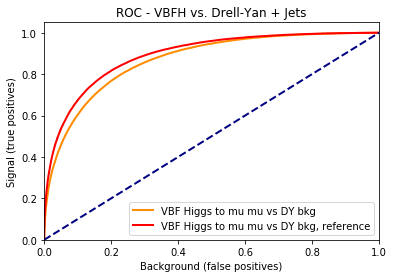

In [59]:
fpr_dy_ref, tpr_dy_ref, _ = roc_curve(subset_dy_vbf['label'].values, subset_dy_vbf['label_ref'].values)


#fpr_ref, tpr_ref, _ = roc_curve(y_test, x_test[:,dnn_var_indices])
#plot roc curve
plt.figure()
lw = 2
plt.plot(fpr_dy, tpr_dy, color='darkorange',
         lw=lw, label=r'VBF Higgs to mu mu vs DY bkg')
plt.plot(fpr_dy_ref, tpr_dy_ref, color='red',
         lw=lw, label=r'VBF Higgs to mu mu vs DY bkg, reference')


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background (false positives)')
plt.ylabel('Signal (true positives)')
plt.title(r'ROC - VBFH vs. Drell-Yan + Jets')
plt.legend(loc="lower right")
plt.savefig('compareDY_' + test_name + '.png')

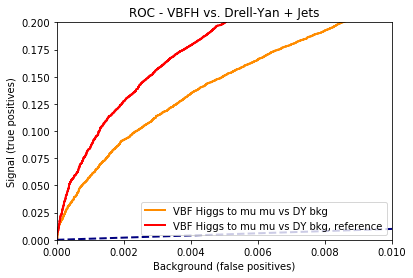

In [61]:
fpr_dy_ref, tpr_dy_ref, _ = roc_curve(subset_dy_vbf['label'].values, subset_dy_vbf['label_ref'].values)
#plot roc curve
plt.figure()
lw = 2
plt.plot(fpr_dy, tpr_dy, color='darkorange',
         lw=lw, label=r'VBF Higgs to mu mu vs DY bkg')
plt.plot(fpr_dy_ref, tpr_dy_ref, color='red',
         lw=lw, label=r'VBF Higgs to mu mu vs DY bkg, reference')


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 0.01])
plt.ylim([0.0, 0.2])
plt.xlabel('Background (false positives)')
plt.ylabel('Signal (true positives)')
plt.title(r'ROC - VBFH vs. Drell-Yan + Jets')
plt.legend(loc="lower right")
plt.savefig('compareDY_zoom_' + test_name + '.png')

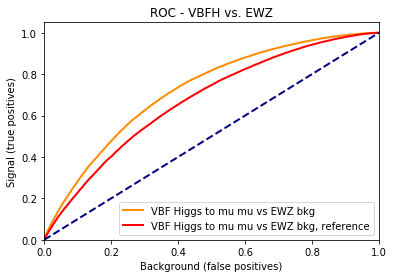

In [60]:
fpr_ewz_ref, tpr_ewz_ref, _ = roc_curve(subset_ewz_vbf['label'].values, subset_ewz_vbf['label_ref'].values)
#plot roc curve
plt.figure()
lw = 2
plt.plot(fpr_ewz, tpr_ewz, color='darkorange',
         lw=lw, label=r'VBF Higgs to mu mu vs EWZ bkg')
plt.plot(fpr_ewz_ref, tpr_ewz_ref, color='red',
         lw=lw, label=r'VBF Higgs to mu mu vs EWZ bkg, reference')


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background (false positives)')
plt.ylabel('Signal (true positives)')
plt.title(r'ROC - VBFH vs. EWZ')
plt.legend(loc="lower right")
plt.savefig('compareEWZ_' + test_name + '.png')